In [1]:
!chcp 65001
!echo 中文在我的電腦顯示會是亂碼耶  

Active code page: 65001


�L�k��R AutoRun �n�����X�����w���ȡC


中文在我的電腦顯示會是亂碼耶


The value specified in an AutoRun registry key could not be parsed.


In [2]:
import torch
import os, cv2, random, glob
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms, models, datasets
from torchvision.ops import nms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import warnings
import configparser
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
import logging
logger = logging.getLogger(__name__)

In [4]:
# Load configuration
config = configparser.ConfigParser()
config.read('config.ini')
# Load parameters from config file
root = config.get('DEFAULT', 'root_dir')
IMAGE_ROOT = os.path.join(root, 'images/images')
DF_RAW = df = pd.read_csv(os.path.join(root, 'df.csv'))
DF_RAW = df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

In [5]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [6]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
    
class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        logger.info(f'{len(self)} items loaded')
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = f'{self.image_dir}/{image_id}.jpg'
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels
    def __len__(self):
        return len(self.image_infos)

In [7]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

(21598, 2464)

In [8]:
train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=20, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=20, collate_fn=test_ds.collate_fn, drop_last=True)

In [9]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
    
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [10]:
from model import SSD300, MultiBoxLoss
from detect import *

In [11]:
n_epochs = 5

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)


Loaded base model.



In [12]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        print(f"Epoch {epoch+1}/{n_epochs}, Batch {ix+1}/{_n}, Loss: {loss.item()}")
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        print(f"Epoch {epoch+1}/{n_epochs}, Batch {ix+1}/{_n}, Loss: {loss.item()}")
    
torch.save(model.state_dict(), '08_3_Training_SSD.pth')

Epoch 1/5, Batch 1/685, Loss: 17.41547966003418
Epoch 1/5, Batch 2/685, Loss: 15.135332107543945
Epoch 1/5, Batch 3/685, Loss: 13.06117057800293
Epoch 1/5, Batch 4/685, Loss: 10.623111724853516
Epoch 1/5, Batch 5/685, Loss: 8.521004676818848
Epoch 1/5, Batch 6/685, Loss: 7.089126110076904
Epoch 1/5, Batch 7/685, Loss: 6.411334991455078
Epoch 1/5, Batch 8/685, Loss: 6.297464847564697
Epoch 1/5, Batch 9/685, Loss: 6.033852577209473
Epoch 1/5, Batch 10/685, Loss: 5.853567123413086
Epoch 1/5, Batch 11/685, Loss: 6.200875282287598
Epoch 1/5, Batch 12/685, Loss: 6.036409378051758
Epoch 1/5, Batch 13/685, Loss: 6.3299241065979
Epoch 1/5, Batch 14/685, Loss: 5.97091817855835
Epoch 1/5, Batch 15/685, Loss: 5.908316612243652
Epoch 1/5, Batch 16/685, Loss: 6.776492595672607
Epoch 1/5, Batch 17/685, Loss: 5.4510498046875
Epoch 1/5, Batch 18/685, Loss: 5.386155605316162
Epoch 1/5, Batch 19/685, Loss: 6.014439582824707
Epoch 1/5, Batch 20/685, Loss: 5.432590961456299
Epoch 1/5, Batch 21/685, Loss: 5

In [13]:
def show(image, bbs=None, texts=None, ax=None, title=None, sz=10, text_sz=1):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(sz,sz))
    text_sz = text_sz if text_sz else (max(sz) * 3 // 5)
    if title:
        ax.set_title(title)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if bbs is not None:
        for ix, bb in enumerate(bbs):
            x,y,X,Y = bb
            cv2.rectangle(image, (x,y), (X,Y), (0,255,0), text_sz)
            cv2.putText(image, texts[ix], (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), text_sz)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #plt.imshow(img[:,:,::-1]) BGR->RGB剛好是倒過來，可以用-1
    ax.imshow(image)

In [14]:
from model import SSD300
# 初始化模型
model = SSD300(num_classes, device)
# 載入模型權重
model.load_state_dict(torch.load('08_3_Training_SSD.pth', map_location=device))
model.eval()


Loaded base model.



SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

[[16, 35, 197, 138]] ['Truck @ 0.99']
[[0, 0, 256, 171]] ['background @ 0.00']
[[6, 12, 228, 103]] ['Bus @ 1.00']
[[54, 31, 211, 119], [0, 47, 84, 105]] ['Bus @ 0.99', 'Bus @ 0.91']
[[0, 0, 256, 129]] ['background @ 0.00']


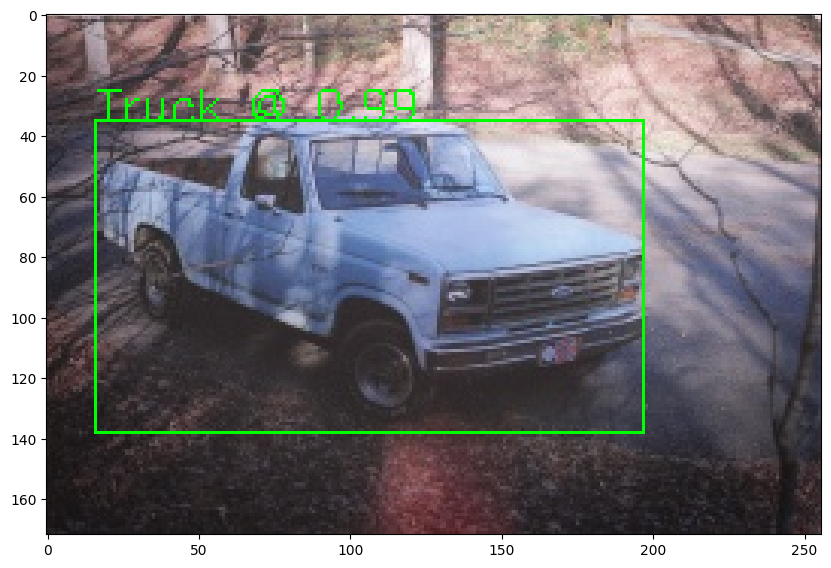

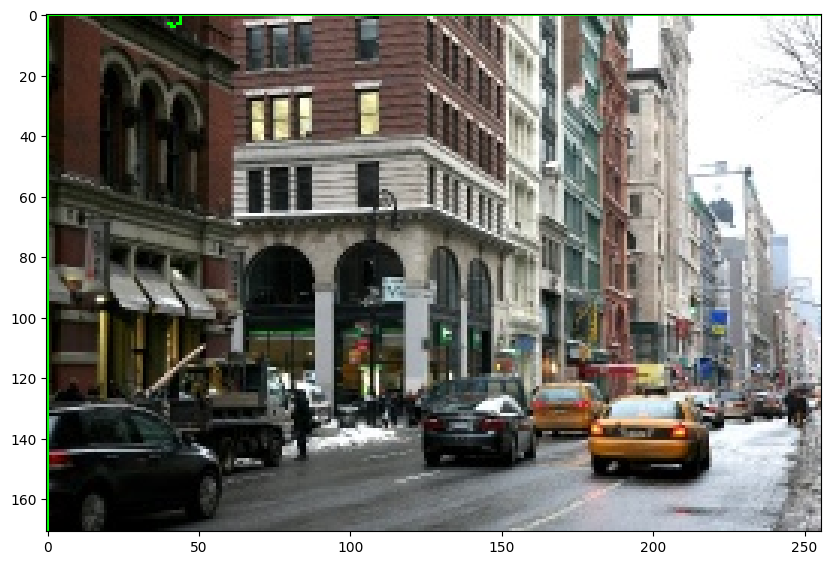

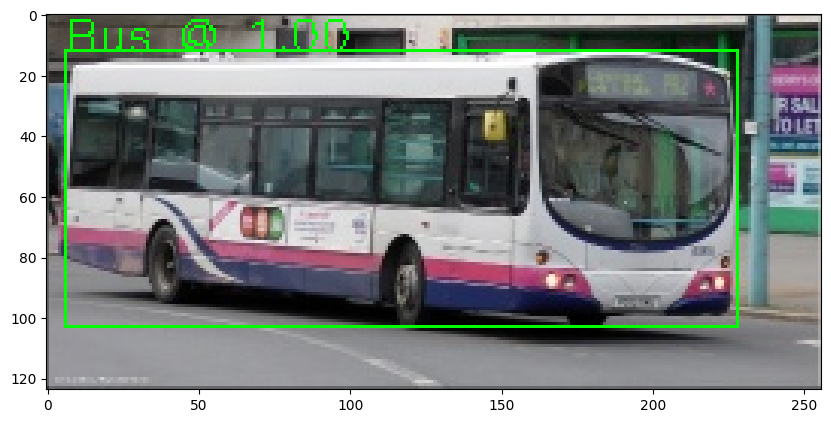

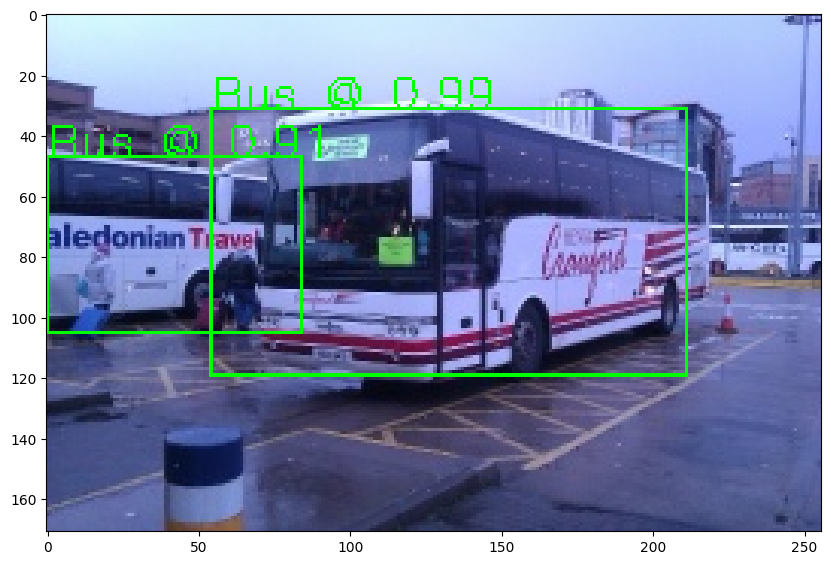

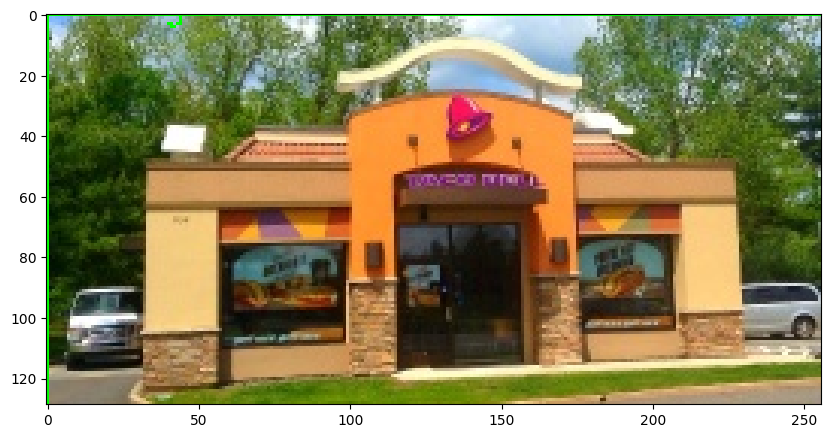

In [15]:
# 隨機從DF_RAW裡挑選五筆資料
sampled_rows = DF_RAW.sample(n=5)

# 取出 ImageID 欄位並加上 .jpg
image_filenames = sampled_rows['ImageID'].apply(lambda x: f"{x}.jpg").tolist()

for filename in image_filenames:
    img_path = os.path.join(IMAGE_ROOT, filename)    
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(np.array(original_image), bbs=bbs, texts=label_with_conf, text_sz=1)
